# 

title: Regression and KMeans Modeling Analysis author: - name: Caroline
O’Sullivan affiliations: - id: bu name: Boston University city: Boston
state: MA - name: Bhargavi Manyala affiliations: - ref: bu - name:
Taylor Luckenbill affiliations: - ref: bu bibliography: bibliography.bib
csl: csl/econometrica.csl format: html: toc: true number-sections: true
df-print: paged engine: jupyter jupyter: python3 execute: echo: true
eval: true output: true freeze: auto —

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt



spark = SparkSession.builder \
    .appName("JobPostingsAnalysis") \
    .getOrCreate()

file_path = "data/lightcast_job_postings.csv"

df_c = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(file_path)
df_c.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/10/09 22:03:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25/10/09 22:03:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+

In [2]:
from pyspark.sql.functions import regexp_replace, trim, col, split, explode

df_clean = df_c.withColumn(
    "SPECIALIZED_SKILLS_NAME",
    regexp_replace(col("SPECIALIZED_SKILLS_NAME"), r"[\[\]\n\"]", "")
)


In [3]:
import numpy as np
from pyspark.sql.functions import expr, col, when

# Calculate overall median salary
overall_median_salary = df_clean.approxQuantile("SALARY", [0.5], 0.01)[0]

# Median by employment type
median_by_employment_type = df_clean.groupBy("EMPLOYMENT_TYPE") \
    .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type"))

# Median by employment type name
median_by_employment_type_name = df_clean.groupBy("EMPLOYMENT_TYPE_NAME") \
    .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name"))

# Join and fill missing salaries
df_clean = df_clean.join(
    median_by_employment_type_name,
    on="EMPLOYMENT_TYPE_NAME",
    how="left"
).withColumn(
    "SALARY",
    when(col("SALARY").isNotNull(), col("SALARY"))
    .when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
    .otherwise(overall_median_salary)
).drop("median_salary_emp_type_name")
df_selected = df_clean.select("SALARY", "NAICS_2022_2_NAME", "SPECIALIZED_SKILLS_NAME")
df_selected.dropna()

DataFrame[SALARY: double, NAICS_2022_2_NAME: string, SPECIALIZED_SKILLS_NAME: string]

In [4]:
from pyspark.sql.functions import when, lower, sum, avg, col, split, trim, lower, size, array_intersect, array
from pyspark.sql.types import IntegerType


ai_skills = [
    "machine learning", "artificial intelligence", "deep learning", "data science",
    "neural networks", "computer vision", "natural language processing",
    "nlp", "ai", "automation", "predictive analytics", "data mining",
    "tensorflow", "pytorch", "data engineering", "big data"
]



# Create a column as an array of skills
df_array = df_selected.withColumn(
    "skills_array",
    split(lower(col("SPECIALIZED_SKILLS_NAME")), ",")
)

# Trim whitespace from array elements
from pyspark.sql.functions import expr
df_array = df_array.withColumn(
    "skills_array",
    expr("transform(skills_array, x -> trim(x))")
)

# Define AI skills as a Spark array
ai_skills_spark = array(*[expr(f"'{s}'") for s in ai_skills])

# Count AI skills using array_intersect
df_features = df_array.withColumn(
    "AI_skill_count",
    size(array_intersect(col("skills_array"), ai_skills_spark))
)

df_industry = df_features.groupBy("NAICS_2022_2_NAME").agg(
    avg("AI_skill_count").alias("avg_ai_skills"),
    expr("percentile_approx(SALARY, 0.5)").alias("median_salary")
)
df_industry = df_industry.dropna(subset=["NAICS_2022_2_NAME"])
df_industry.orderBy(col("avg_ai_skills").desc()).show(10, truncate=False)


+---------------------------------------------+-------------------+-------------+
|NAICS_2022_2_NAME                            |avg_ai_skills      |median_salary|
+---------------------------------------------+-------------------+-------------+
|Transportation and Warehousing               |0.6951219512195121 |116500.0     |
|Real Estate and Rental and Leasing           |0.6722689075630253 |116500.0     |
|Manufacturing                                |0.6488502175264139 |116500.0     |
|Information                                  |0.6203680362994707 |116500.0     |
|Mining, Quarrying, and Oil and Gas Extraction|0.6011904761904762 |116500.0     |
|Finance and Insurance                        |0.5863524925088531 |116500.0     |
|Management of Companies and Enterprises      |0.5793357933579336 |116500.0     |
|Retail Trade                                 |0.4976958525345622 |116500.0     |
|Utilities                                    |0.49117647058823527|116500.0     |
|Health Care and

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Index industry
indexer = StringIndexer(inputCol="NAICS_2022_2_NAME", outputCol="industry_idx")
df_indexed = indexer.fit(df_industry).transform(df_industry)

# One-hot encode
encoder = OneHotEncoder(inputCol="industry_idx", outputCol="industry_vec")
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# Assemble features
assembler = VectorAssembler(
    inputCols=["avg_ai_skills", "median_salary", "industry_vec"],
    outputCol="features"
)
df_features_final = assembler.transform(df_encoded)
df_features_final.select("features").show(5, truncate=False)



+------------------------------------------------+
|features                                        |
+------------------------------------------------+
|(22,[0,1,3],[0.2765414928140936,116500.0,1.0])  |
|(22,[0,1,16],[0.35360824742268043,87216.0,1.0]) |
|(22,[0,1,17],[0.6722689075630253,116500.0,1.0]) |
|(22,[0,1,10],[0.6203680362994707,116500.0,1.0]) |
|(22,[0,1,20],[0.32166947723440137,116500.0,1.0])|
+------------------------------------------------+
only showing top 5 rows



In [6]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# 1. Initialize KMeans
kmeans = KMeans(featuresCol="features", k=5, seed=42)  # choose k as desired

# 2. Fit model
model = kmeans.fit(df_features_final)

# 3. Make predictions
predictions = model.transform(df_features_final)

# 4. Evaluate clustering (optional)
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score: {silhouette}")

# 5. Inspect cluster centers
centers = model.clusterCenters()
print("Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# 6. Show cluster assignments
predictions.select("NAICS_2022_2_NAME", "avg_ai_skills", "median_salary", "prediction").show(10, truncate=False)

Silhouette score: 0.8571427451623391
Cluster Centers:
Cluster 0: [4.67534910e-01 1.16500000e+05 5.55555556e-02 5.55555556e-02
 5.55555556e-02 0.00000000e+00 5.55555556e-02 0.00000000e+00
 5.55555556e-02 5.55555556e-02 5.55555556e-02 5.55555556e-02
 5.55555556e-02 5.55555556e-02 5.55555556e-02 5.55555556e-02
 0.00000000e+00 5.55555556e-02 5.55555556e-02 5.55555556e-02
 5.55555556e-02 5.55555556e-02]
Cluster 1: [3.53608247e-01 8.72160000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Cluster 2: [4.28143713e-01 1.07500000e+05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

+------------------------------------------------------------------------+-------------------+-------------+----------+
|NAICS_2022_2_NAME                                                       |avg_ai_skills      |median_salary|prediction|
+------------------------------------------------------------------------+-------------------+-------------+----------+
|Administrative and Support and Waste Management and Remediation Services|0.2765414928140936 |116500.0     |0         |
|Public Administration                                                   |0.35360824742268043|87216.0      |1         |
|Real Estate and Rental and Leasing                                      |0.6722689075630253 |116500.0     |0         |
|Information                                                             |0.6203680362994707 |116500.0     |0         |
|Unclassified Industry                                                   |0.32166947723440137|116500.0     |0         |
|Accommodation and Food Services        

In [7]:
from pyspark.sql.functions import avg, count

cluster_summary = predictions.groupBy("prediction", "NAICS_2022_2_NAME").agg(
    avg("avg_ai_skills").alias("avg_ai_skills"),
    avg("median_salary").alias("median_salary"),
    count("*").alias("num_postings")
).orderBy("prediction")

cluster_summary.show(20, truncate=False)


+----------+------------------------------------------------------------------------+-------------------+-------------+------------+
|prediction|NAICS_2022_2_NAME                                                       |avg_ai_skills      |median_salary|num_postings|
+----------+------------------------------------------------------------------------+-------------------+-------------+------------+
|0         |Information                                                             |0.6203680362994707 |116500.0     |1           |
|0         |Real Estate and Rental and Leasing                                      |0.6722689075630253 |116500.0     |1           |
|0         |Finance and Insurance                                                   |0.5863524925088531 |116500.0     |1           |
|0         |Construction                                                            |0.3709677419354839 |116500.0     |1           |
|0         |Utilities                                                

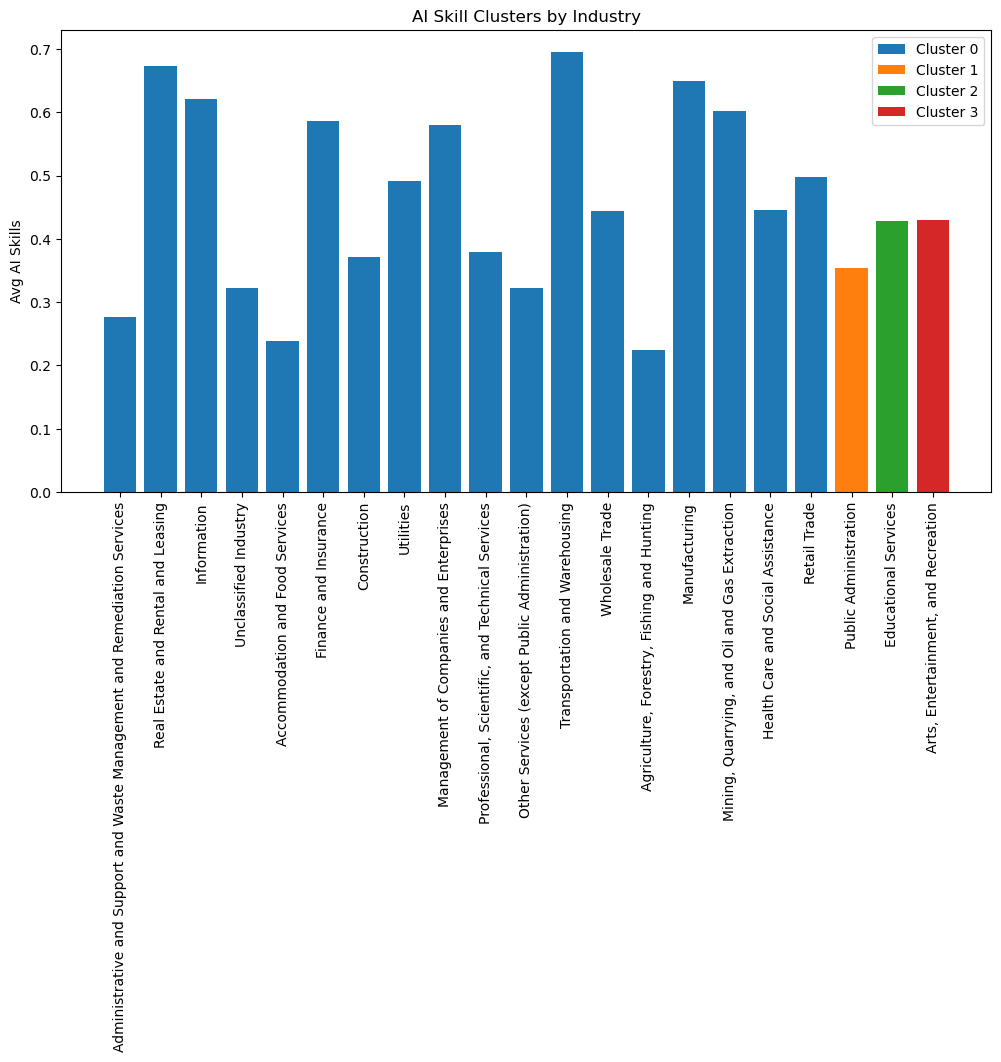

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas
cluster_pd = cluster_summary.toPandas()

plt.figure(figsize=(12,6))
for cluster in cluster_pd['prediction'].unique():
    subset = cluster_pd[cluster_pd['prediction'] == cluster]
    plt.bar(subset['NAICS_2022_2_NAME'], subset['avg_ai_skills'], label=f"Cluster {cluster}")

plt.xticks(rotation=90)
plt.ylabel("Avg AI Skills")
plt.title("AI Skill Clusters by Industry")
plt.legend()
plt.show()



In [15]:
from pyspark.ml.feature import PCA

# Keep only the needed columns for PCA transform
df_pca_input = df_features_final.select("features", "NAICS_2022_2_NAME", "prediction")

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_pca_input)
pca_result = pca_model.transform(df_pca_input)  # This keeps the extra columns

# Convert to Pandas
pca_pd = pca_result.select("pca_features", "NAICS_2022_2_NAME", "prediction").toPandas()

# Extract the two PCA components
pca_pd["x"] = pca_pd["pca_features"].apply(lambda v: v[0])
pca_pd["y"] = pca_pd["pca_features"].apply(lambda v: v[1])


AnalysisException: Column 'prediction' does not exist. Did you mean one of the following? [features, industry_idx, avg_ai_skills, industry_vec, median_salary, NAICS_2022_2_NAME];
'Project [features#5148, NAICS_2022_2_NAME#122, 'prediction]
+- Project [NAICS_2022_2_NAME#122, avg_ai_skills#4946, median_salary#4947, industry_idx#5123, industry_vec#5135, UDF(struct(avg_ai_skills, avg_ai_skills#4946, median_salary, median_salary#4947, industry_vec, industry_vec#5135)) AS features#5148]
   +- Project [NAICS_2022_2_NAME#122, avg_ai_skills#4946, median_salary#4947, industry_idx#5123, UDF(cast(industry_idx#5123 as double), 0) AS industry_vec#5135]
      +- Project [NAICS_2022_2_NAME#122, avg_ai_skills#4946, median_salary#4947, UDF(cast(NAICS_2022_2_NAME#122 as string)) AS industry_idx#5123]
         +- Filter atleastnnonnulls(1, NAICS_2022_2_NAME#122)
            +- Aggregate [NAICS_2022_2_NAME#122], [NAICS_2022_2_NAME#122, avg(AI_skill_count#4934) AS avg_ai_skills#4946, percentile_approx(SALARY#4299, cast(0.5 as double), 10000, 0, 0) AS median_salary#4947]
               +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919, skills_array#4928, size(array_intersect(skills_array#4928, array(machine learning, artificial intelligence, deep learning, data science, neural networks, computer vision, natural language processing, nlp, ai, automation, predictive analytics, data mining, tensorflow, pytorch, data engineering, big data)), true) AS AI_skill_count#4934]
                  +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919, transform(skills_array#4923, lambdafunction(trim(lambda x#4929, None), lambda x#4929, false)) AS skills_array#4928]
                     +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919, split(lower(SPECIALIZED_SKILLS_NAME#919), ,, -1) AS skills_array#4923]
                        +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919]
                           +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 107 more fields]
                              +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                 +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                    +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#27 = EMPLOYMENT_TYPE_NAME#3666)
                                       :- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 107 more fields]
                                       :  +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                       :     +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                       :        +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#27 = EMPLOYMENT_TYPE_NAME#2435)
                                       :           :- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 107 more fields]
                                       :           :  +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                       :           :     +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                       :           :        +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#27 = EMPLOYMENT_TYPE_NAME#1484)
                                       :           :           :- Project [ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, MIN_EDULEVELS_NAME#23, ... 107 more fields]
                                       :           :           :  +- Relation [ID#0,LAST_UPDATED_DATE#1,LAST_UPDATED_TIMESTAMP#2,DUPLICATES#3,POSTED#4,EXPIRED#5,DURATION#6,SOURCE_TYPES#7,SOURCES#8,URL#9,ACTIVE_URLS#10,ACTIVE_SOURCES_INFO#11,TITLE_RAW#12,BODY#13,MODELED_EXPIRED#14,MODELED_DURATION#15,COMPANY#16,COMPANY_NAME#17,COMPANY_RAW#18,COMPANY_IS_STAFFING#19,EDUCATION_LEVELS#20,EDUCATION_LEVELS_NAME#21,MIN_EDULEVELS#22,MIN_EDULEVELS_NAME#23,... 107 more fields] csv
                                       :           :           +- Aggregate [EMPLOYMENT_TYPE_NAME#1484], [EMPLOYMENT_TYPE_NAME#1484, percentile_approx(SALARY#1488, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                       :           :              +- Project [ID#1457, LAST_UPDATED_DATE#1458, LAST_UPDATED_TIMESTAMP#1459, DUPLICATES#1460, POSTED#1461, EXPIRED#1462, DURATION#1463, SOURCE_TYPES#1464, SOURCES#1465, URL#1466, ACTIVE_URLS#1467, ACTIVE_SOURCES_INFO#1468, TITLE_RAW#1469, BODY#1470, MODELED_EXPIRED#1471, MODELED_DURATION#1472, COMPANY#1473, COMPANY_NAME#1474, COMPANY_RAW#1475, COMPANY_IS_STAFFING#1476, EDUCATION_LEVELS#1477, EDUCATION_LEVELS_NAME#1478, MIN_EDULEVELS#1479, MIN_EDULEVELS_NAME#1480, ... 107 more fields]
                                       :           :                 +- Relation [ID#1457,LAST_UPDATED_DATE#1458,LAST_UPDATED_TIMESTAMP#1459,DUPLICATES#1460,POSTED#1461,EXPIRED#1462,DURATION#1463,SOURCE_TYPES#1464,SOURCES#1465,URL#1466,ACTIVE_URLS#1467,ACTIVE_SOURCES_INFO#1468,TITLE_RAW#1469,BODY#1470,MODELED_EXPIRED#1471,MODELED_DURATION#1472,COMPANY#1473,COMPANY_NAME#1474,COMPANY_RAW#1475,COMPANY_IS_STAFFING#1476,EDUCATION_LEVELS#1477,EDUCATION_LEVELS_NAME#1478,MIN_EDULEVELS#1479,MIN_EDULEVELS_NAME#1480,... 107 more fields] csv
                                       :           +- Aggregate [EMPLOYMENT_TYPE_NAME#2435], [EMPLOYMENT_TYPE_NAME#2435, percentile_approx(SALARY#1721, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#2404]
                                       :              +- Project [EMPLOYMENT_TYPE_NAME#2435, ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, ... 107 more fields]
                                       :                 +- Project [EMPLOYMENT_TYPE_NAME#2435, ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, ... 108 more fields]
                                       :                    +- Project [EMPLOYMENT_TYPE_NAME#2435, ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, ... 108 more fields]
                                       :                       +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#2435 = EMPLOYMENT_TYPE_NAME#2566)
                                       :                          :- Project [ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, MIN_EDULEVELS_NAME#2431, ... 107 more fields]
                                       :                          :  +- Relation [ID#2408,LAST_UPDATED_DATE#2409,LAST_UPDATED_TIMESTAMP#2410,DUPLICATES#2411,POSTED#2412,EXPIRED#2413,DURATION#2414,SOURCE_TYPES#2415,SOURCES#2416,URL#2417,ACTIVE_URLS#2418,ACTIVE_SOURCES_INFO#2419,TITLE_RAW#2420,BODY#2421,MODELED_EXPIRED#2422,MODELED_DURATION#2423,COMPANY#2424,COMPANY_NAME#2425,COMPANY_RAW#2426,COMPANY_IS_STAFFING#2427,EDUCATION_LEVELS#2428,EDUCATION_LEVELS_NAME#2429,MIN_EDULEVELS#2430,MIN_EDULEVELS_NAME#2431,... 107 more fields] csv
                                       :                          +- Aggregate [EMPLOYMENT_TYPE_NAME#2566], [EMPLOYMENT_TYPE_NAME#2566, percentile_approx(SALARY#2570, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                       :                             +- Project [ID#2539, LAST_UPDATED_DATE#2540, LAST_UPDATED_TIMESTAMP#2541, DUPLICATES#2542, POSTED#2543, EXPIRED#2544, DURATION#2545, SOURCE_TYPES#2546, SOURCES#2547, URL#2548, ACTIVE_URLS#2549, ACTIVE_SOURCES_INFO#2550, TITLE_RAW#2551, BODY#2552, MODELED_EXPIRED#2553, MODELED_DURATION#2554, COMPANY#2555, COMPANY_NAME#2556, COMPANY_RAW#2557, COMPANY_IS_STAFFING#2558, EDUCATION_LEVELS#2559, EDUCATION_LEVELS_NAME#2560, MIN_EDULEVELS#2561, MIN_EDULEVELS_NAME#2562, ... 107 more fields]
                                       :                                +- Relation [ID#2539,LAST_UPDATED_DATE#2540,LAST_UPDATED_TIMESTAMP#2541,DUPLICATES#2542,POSTED#2543,EXPIRED#2544,DURATION#2545,SOURCE_TYPES#2546,SOURCES#2547,URL#2548,ACTIVE_URLS#2549,ACTIVE_SOURCES_INFO#2550,TITLE_RAW#2551,BODY#2552,MODELED_EXPIRED#2553,MODELED_DURATION#2554,COMPANY#2555,COMPANY_NAME#2556,COMPANY_RAW#2557,COMPANY_IS_STAFFING#2558,EDUCATION_LEVELS#2559,EDUCATION_LEVELS_NAME#2560,MIN_EDULEVELS#2561,MIN_EDULEVELS_NAME#2562,... 107 more fields] csv
                                       +- Aggregate [EMPLOYMENT_TYPE_NAME#3666], [EMPLOYMENT_TYPE_NAME#3666, percentile_approx(SALARY#2804, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#3635]
                                          +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 107 more fields]
                                             +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                   +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#3666 = EMPLOYMENT_TYPE_NAME#3928)
                                                      :- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 107 more fields]
                                                      :  +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                      :     +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                      :        +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#3666 = EMPLOYMENT_TYPE_NAME#3797)
                                                      :           :- Project [ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, MIN_EDULEVELS_NAME#3662, ... 107 more fields]
                                                      :           :  +- Relation [ID#3639,LAST_UPDATED_DATE#3640,LAST_UPDATED_TIMESTAMP#3641,DUPLICATES#3642,POSTED#3643,EXPIRED#3644,DURATION#3645,SOURCE_TYPES#3646,SOURCES#3647,URL#3648,ACTIVE_URLS#3649,ACTIVE_SOURCES_INFO#3650,TITLE_RAW#3651,BODY#3652,MODELED_EXPIRED#3653,MODELED_DURATION#3654,COMPANY#3655,COMPANY_NAME#3656,COMPANY_RAW#3657,COMPANY_IS_STAFFING#3658,EDUCATION_LEVELS#3659,EDUCATION_LEVELS_NAME#3660,MIN_EDULEVELS#3661,MIN_EDULEVELS_NAME#3662,... 107 more fields] csv
                                                      :           +- Aggregate [EMPLOYMENT_TYPE_NAME#3797], [EMPLOYMENT_TYPE_NAME#3797, percentile_approx(SALARY#3801, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                                      :              +- Project [ID#3770, LAST_UPDATED_DATE#3771, LAST_UPDATED_TIMESTAMP#3772, DUPLICATES#3773, POSTED#3774, EXPIRED#3775, DURATION#3776, SOURCE_TYPES#3777, SOURCES#3778, URL#3779, ACTIVE_URLS#3780, ACTIVE_SOURCES_INFO#3781, TITLE_RAW#3782, BODY#3783, MODELED_EXPIRED#3784, MODELED_DURATION#3785, COMPANY#3786, COMPANY_NAME#3787, COMPANY_RAW#3788, COMPANY_IS_STAFFING#3789, EDUCATION_LEVELS#3790, EDUCATION_LEVELS_NAME#3791, MIN_EDULEVELS#3792, MIN_EDULEVELS_NAME#3793, ... 107 more fields]
                                                      :                 +- Relation [ID#3770,LAST_UPDATED_DATE#3771,LAST_UPDATED_TIMESTAMP#3772,DUPLICATES#3773,POSTED#3774,EXPIRED#3775,DURATION#3776,SOURCE_TYPES#3777,SOURCES#3778,URL#3779,ACTIVE_URLS#3780,ACTIVE_SOURCES_INFO#3781,TITLE_RAW#3782,BODY#3783,MODELED_EXPIRED#3784,MODELED_DURATION#3785,COMPANY#3786,COMPANY_NAME#3787,COMPANY_RAW#3788,COMPANY_IS_STAFFING#3789,EDUCATION_LEVELS#3790,EDUCATION_LEVELS_NAME#3791,MIN_EDULEVELS#3792,MIN_EDULEVELS_NAME#3793,... 107 more fields] csv
                                                      +- Aggregate [EMPLOYMENT_TYPE_NAME#3928], [EMPLOYMENT_TYPE_NAME#3928, percentile_approx(SALARY#1721, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#2404]
                                                         +- Project [EMPLOYMENT_TYPE_NAME#3928, ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, ... 107 more fields]
                                                            +- Project [EMPLOYMENT_TYPE_NAME#3928, ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, ... 108 more fields]
                                                               +- Project [EMPLOYMENT_TYPE_NAME#3928, ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, ... 108 more fields]
                                                                  +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#3928 = EMPLOYMENT_TYPE_NAME#4059)
                                                                     :- Project [ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, MIN_EDULEVELS_NAME#3924, ... 107 more fields]
                                                                     :  +- Relation [ID#3901,LAST_UPDATED_DATE#3902,LAST_UPDATED_TIMESTAMP#3903,DUPLICATES#3904,POSTED#3905,EXPIRED#3906,DURATION#3907,SOURCE_TYPES#3908,SOURCES#3909,URL#3910,ACTIVE_URLS#3911,ACTIVE_SOURCES_INFO#3912,TITLE_RAW#3913,BODY#3914,MODELED_EXPIRED#3915,MODELED_DURATION#3916,COMPANY#3917,COMPANY_NAME#3918,COMPANY_RAW#3919,COMPANY_IS_STAFFING#3920,EDUCATION_LEVELS#3921,EDUCATION_LEVELS_NAME#3922,MIN_EDULEVELS#3923,MIN_EDULEVELS_NAME#3924,... 107 more fields] csv
                                                                     +- Aggregate [EMPLOYMENT_TYPE_NAME#4059], [EMPLOYMENT_TYPE_NAME#4059, percentile_approx(SALARY#4063, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                                                        +- Project [ID#4032, LAST_UPDATED_DATE#4033, LAST_UPDATED_TIMESTAMP#4034, DUPLICATES#4035, POSTED#4036, EXPIRED#4037, DURATION#4038, SOURCE_TYPES#4039, SOURCES#4040, URL#4041, ACTIVE_URLS#4042, ACTIVE_SOURCES_INFO#4043, TITLE_RAW#4044, BODY#4045, MODELED_EXPIRED#4046, MODELED_DURATION#4047, COMPANY#4048, COMPANY_NAME#4049, COMPANY_RAW#4050, COMPANY_IS_STAFFING#4051, EDUCATION_LEVELS#4052, EDUCATION_LEVELS_NAME#4053, MIN_EDULEVELS#4054, MIN_EDULEVELS_NAME#4055, ... 107 more fields]
                                                                           +- Relation [ID#4032,LAST_UPDATED_DATE#4033,LAST_UPDATED_TIMESTAMP#4034,DUPLICATES#4035,POSTED#4036,EXPIRED#4037,DURATION#4038,SOURCE_TYPES#4039,SOURCES#4040,URL#4041,ACTIVE_URLS#4042,ACTIVE_SOURCES_INFO#4043,TITLE_RAW#4044,BODY#4045,MODELED_EXPIRED#4046,MODELED_DURATION#4047,COMPANY#4048,COMPANY_NAME#4049,COMPANY_RAW#4050,COMPANY_IS_STAFFING#4051,EDUCATION_LEVELS#4052,EDUCATION_LEVELS_NAME#4053,MIN_EDULEVELS#4054,MIN_EDULEVELS_NAME#4055,... 107 more fields] csv


In [13]:
# Convert to pandas
pca_pd = pca_result.select("pca_features", "NAICS_2022_2_NAME", "prediction").toPandas()

# Extract the two PCA components
pca_pd["x"] = pca_pd["pca_features"].apply(lambda v: v[0])
pca_pd["y"] = pca_pd["pca_features"].apply(lambda v: v[1])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.scatterplot(
    x="x", y="y",
    hue="prediction",
    data=pca_pd,
    palette="tab10",
    s=100,
    alpha=0.7
)

# Add industry labels (optional, can overlap if too many)
for i, row in pca_pd.iterrows():
    plt.text(row["x"], row["y"], row["NAICS_2022_2_NAME"], fontsize=8)

plt.title("KMeans Clusters by Industry (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


AnalysisException: Column 'prediction' does not exist. Did you mean one of the following? [features, industry_idx, pca_features, avg_ai_skills, industry_vec, median_salary, NAICS_2022_2_NAME];
'Project [pca_features#5420, NAICS_2022_2_NAME#122, 'prediction]
+- Project [NAICS_2022_2_NAME#122, avg_ai_skills#4946, median_salary#4947, industry_idx#5123, industry_vec#5135, features#5148, UDF(features#5148) AS pca_features#5420]
   +- Project [NAICS_2022_2_NAME#122, avg_ai_skills#4946, median_salary#4947, industry_idx#5123, industry_vec#5135, UDF(struct(avg_ai_skills, avg_ai_skills#4946, median_salary, median_salary#4947, industry_vec, industry_vec#5135)) AS features#5148]
      +- Project [NAICS_2022_2_NAME#122, avg_ai_skills#4946, median_salary#4947, industry_idx#5123, UDF(cast(industry_idx#5123 as double), 0) AS industry_vec#5135]
         +- Project [NAICS_2022_2_NAME#122, avg_ai_skills#4946, median_salary#4947, UDF(cast(NAICS_2022_2_NAME#122 as string)) AS industry_idx#5123]
            +- Filter atleastnnonnulls(1, NAICS_2022_2_NAME#122)
               +- Aggregate [NAICS_2022_2_NAME#122], [NAICS_2022_2_NAME#122, avg(AI_skill_count#4934) AS avg_ai_skills#4946, percentile_approx(SALARY#4299, cast(0.5 as double), 10000, 0, 0) AS median_salary#4947]
                  +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919, skills_array#4928, size(array_intersect(skills_array#4928, array(machine learning, artificial intelligence, deep learning, data science, neural networks, computer vision, natural language processing, nlp, ai, automation, predictive analytics, data mining, tensorflow, pytorch, data engineering, big data)), true) AS AI_skill_count#4934]
                     +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919, transform(skills_array#4923, lambdafunction(trim(lambda x#4929, None), lambda x#4929, false)) AS skills_array#4928]
                        +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919, split(lower(SPECIALIZED_SKILLS_NAME#919), ,, -1) AS skills_array#4923]
                           +- Project [SALARY#4299, NAICS_2022_2_NAME#122, SPECIALIZED_SKILLS_NAME#919]
                              +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 107 more fields]
                                 +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                    +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                       +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#27 = EMPLOYMENT_TYPE_NAME#3666)
                                          :- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 107 more fields]
                                          :  +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                          :     +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                          :        +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#27 = EMPLOYMENT_TYPE_NAME#2435)
                                          :           :- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 107 more fields]
                                          :           :  +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                          :           :     +- Project [EMPLOYMENT_TYPE_NAME#27, ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, ... 108 more fields]
                                          :           :        +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#27 = EMPLOYMENT_TYPE_NAME#1484)
                                          :           :           :- Project [ID#0, LAST_UPDATED_DATE#1, LAST_UPDATED_TIMESTAMP#2, DUPLICATES#3, POSTED#4, EXPIRED#5, DURATION#6, SOURCE_TYPES#7, SOURCES#8, URL#9, ACTIVE_URLS#10, ACTIVE_SOURCES_INFO#11, TITLE_RAW#12, BODY#13, MODELED_EXPIRED#14, MODELED_DURATION#15, COMPANY#16, COMPANY_NAME#17, COMPANY_RAW#18, COMPANY_IS_STAFFING#19, EDUCATION_LEVELS#20, EDUCATION_LEVELS_NAME#21, MIN_EDULEVELS#22, MIN_EDULEVELS_NAME#23, ... 107 more fields]
                                          :           :           :  +- Relation [ID#0,LAST_UPDATED_DATE#1,LAST_UPDATED_TIMESTAMP#2,DUPLICATES#3,POSTED#4,EXPIRED#5,DURATION#6,SOURCE_TYPES#7,SOURCES#8,URL#9,ACTIVE_URLS#10,ACTIVE_SOURCES_INFO#11,TITLE_RAW#12,BODY#13,MODELED_EXPIRED#14,MODELED_DURATION#15,COMPANY#16,COMPANY_NAME#17,COMPANY_RAW#18,COMPANY_IS_STAFFING#19,EDUCATION_LEVELS#20,EDUCATION_LEVELS_NAME#21,MIN_EDULEVELS#22,MIN_EDULEVELS_NAME#23,... 107 more fields] csv
                                          :           :           +- Aggregate [EMPLOYMENT_TYPE_NAME#1484], [EMPLOYMENT_TYPE_NAME#1484, percentile_approx(SALARY#1488, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                          :           :              +- Project [ID#1457, LAST_UPDATED_DATE#1458, LAST_UPDATED_TIMESTAMP#1459, DUPLICATES#1460, POSTED#1461, EXPIRED#1462, DURATION#1463, SOURCE_TYPES#1464, SOURCES#1465, URL#1466, ACTIVE_URLS#1467, ACTIVE_SOURCES_INFO#1468, TITLE_RAW#1469, BODY#1470, MODELED_EXPIRED#1471, MODELED_DURATION#1472, COMPANY#1473, COMPANY_NAME#1474, COMPANY_RAW#1475, COMPANY_IS_STAFFING#1476, EDUCATION_LEVELS#1477, EDUCATION_LEVELS_NAME#1478, MIN_EDULEVELS#1479, MIN_EDULEVELS_NAME#1480, ... 107 more fields]
                                          :           :                 +- Relation [ID#1457,LAST_UPDATED_DATE#1458,LAST_UPDATED_TIMESTAMP#1459,DUPLICATES#1460,POSTED#1461,EXPIRED#1462,DURATION#1463,SOURCE_TYPES#1464,SOURCES#1465,URL#1466,ACTIVE_URLS#1467,ACTIVE_SOURCES_INFO#1468,TITLE_RAW#1469,BODY#1470,MODELED_EXPIRED#1471,MODELED_DURATION#1472,COMPANY#1473,COMPANY_NAME#1474,COMPANY_RAW#1475,COMPANY_IS_STAFFING#1476,EDUCATION_LEVELS#1477,EDUCATION_LEVELS_NAME#1478,MIN_EDULEVELS#1479,MIN_EDULEVELS_NAME#1480,... 107 more fields] csv
                                          :           +- Aggregate [EMPLOYMENT_TYPE_NAME#2435], [EMPLOYMENT_TYPE_NAME#2435, percentile_approx(SALARY#1721, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#2404]
                                          :              +- Project [EMPLOYMENT_TYPE_NAME#2435, ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, ... 107 more fields]
                                          :                 +- Project [EMPLOYMENT_TYPE_NAME#2435, ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, ... 108 more fields]
                                          :                    +- Project [EMPLOYMENT_TYPE_NAME#2435, ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, ... 108 more fields]
                                          :                       +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#2435 = EMPLOYMENT_TYPE_NAME#2566)
                                          :                          :- Project [ID#2408, LAST_UPDATED_DATE#2409, LAST_UPDATED_TIMESTAMP#2410, DUPLICATES#2411, POSTED#2412, EXPIRED#2413, DURATION#2414, SOURCE_TYPES#2415, SOURCES#2416, URL#2417, ACTIVE_URLS#2418, ACTIVE_SOURCES_INFO#2419, TITLE_RAW#2420, BODY#2421, MODELED_EXPIRED#2422, MODELED_DURATION#2423, COMPANY#2424, COMPANY_NAME#2425, COMPANY_RAW#2426, COMPANY_IS_STAFFING#2427, EDUCATION_LEVELS#2428, EDUCATION_LEVELS_NAME#2429, MIN_EDULEVELS#2430, MIN_EDULEVELS_NAME#2431, ... 107 more fields]
                                          :                          :  +- Relation [ID#2408,LAST_UPDATED_DATE#2409,LAST_UPDATED_TIMESTAMP#2410,DUPLICATES#2411,POSTED#2412,EXPIRED#2413,DURATION#2414,SOURCE_TYPES#2415,SOURCES#2416,URL#2417,ACTIVE_URLS#2418,ACTIVE_SOURCES_INFO#2419,TITLE_RAW#2420,BODY#2421,MODELED_EXPIRED#2422,MODELED_DURATION#2423,COMPANY#2424,COMPANY_NAME#2425,COMPANY_RAW#2426,COMPANY_IS_STAFFING#2427,EDUCATION_LEVELS#2428,EDUCATION_LEVELS_NAME#2429,MIN_EDULEVELS#2430,MIN_EDULEVELS_NAME#2431,... 107 more fields] csv
                                          :                          +- Aggregate [EMPLOYMENT_TYPE_NAME#2566], [EMPLOYMENT_TYPE_NAME#2566, percentile_approx(SALARY#2570, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                          :                             +- Project [ID#2539, LAST_UPDATED_DATE#2540, LAST_UPDATED_TIMESTAMP#2541, DUPLICATES#2542, POSTED#2543, EXPIRED#2544, DURATION#2545, SOURCE_TYPES#2546, SOURCES#2547, URL#2548, ACTIVE_URLS#2549, ACTIVE_SOURCES_INFO#2550, TITLE_RAW#2551, BODY#2552, MODELED_EXPIRED#2553, MODELED_DURATION#2554, COMPANY#2555, COMPANY_NAME#2556, COMPANY_RAW#2557, COMPANY_IS_STAFFING#2558, EDUCATION_LEVELS#2559, EDUCATION_LEVELS_NAME#2560, MIN_EDULEVELS#2561, MIN_EDULEVELS_NAME#2562, ... 107 more fields]
                                          :                                +- Relation [ID#2539,LAST_UPDATED_DATE#2540,LAST_UPDATED_TIMESTAMP#2541,DUPLICATES#2542,POSTED#2543,EXPIRED#2544,DURATION#2545,SOURCE_TYPES#2546,SOURCES#2547,URL#2548,ACTIVE_URLS#2549,ACTIVE_SOURCES_INFO#2550,TITLE_RAW#2551,BODY#2552,MODELED_EXPIRED#2553,MODELED_DURATION#2554,COMPANY#2555,COMPANY_NAME#2556,COMPANY_RAW#2557,COMPANY_IS_STAFFING#2558,EDUCATION_LEVELS#2559,EDUCATION_LEVELS_NAME#2560,MIN_EDULEVELS#2561,MIN_EDULEVELS_NAME#2562,... 107 more fields] csv
                                          +- Aggregate [EMPLOYMENT_TYPE_NAME#3666], [EMPLOYMENT_TYPE_NAME#3666, percentile_approx(SALARY#2804, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#3635]
                                             +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 107 more fields]
                                                +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                   +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                      +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#3666 = EMPLOYMENT_TYPE_NAME#3928)
                                                         :- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 107 more fields]
                                                         :  +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                         :     +- Project [EMPLOYMENT_TYPE_NAME#3666, ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, ... 108 more fields]
                                                         :        +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#3666 = EMPLOYMENT_TYPE_NAME#3797)
                                                         :           :- Project [ID#3639, LAST_UPDATED_DATE#3640, LAST_UPDATED_TIMESTAMP#3641, DUPLICATES#3642, POSTED#3643, EXPIRED#3644, DURATION#3645, SOURCE_TYPES#3646, SOURCES#3647, URL#3648, ACTIVE_URLS#3649, ACTIVE_SOURCES_INFO#3650, TITLE_RAW#3651, BODY#3652, MODELED_EXPIRED#3653, MODELED_DURATION#3654, COMPANY#3655, COMPANY_NAME#3656, COMPANY_RAW#3657, COMPANY_IS_STAFFING#3658, EDUCATION_LEVELS#3659, EDUCATION_LEVELS_NAME#3660, MIN_EDULEVELS#3661, MIN_EDULEVELS_NAME#3662, ... 107 more fields]
                                                         :           :  +- Relation [ID#3639,LAST_UPDATED_DATE#3640,LAST_UPDATED_TIMESTAMP#3641,DUPLICATES#3642,POSTED#3643,EXPIRED#3644,DURATION#3645,SOURCE_TYPES#3646,SOURCES#3647,URL#3648,ACTIVE_URLS#3649,ACTIVE_SOURCES_INFO#3650,TITLE_RAW#3651,BODY#3652,MODELED_EXPIRED#3653,MODELED_DURATION#3654,COMPANY#3655,COMPANY_NAME#3656,COMPANY_RAW#3657,COMPANY_IS_STAFFING#3658,EDUCATION_LEVELS#3659,EDUCATION_LEVELS_NAME#3660,MIN_EDULEVELS#3661,MIN_EDULEVELS_NAME#3662,... 107 more fields] csv
                                                         :           +- Aggregate [EMPLOYMENT_TYPE_NAME#3797], [EMPLOYMENT_TYPE_NAME#3797, percentile_approx(SALARY#3801, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                                         :              +- Project [ID#3770, LAST_UPDATED_DATE#3771, LAST_UPDATED_TIMESTAMP#3772, DUPLICATES#3773, POSTED#3774, EXPIRED#3775, DURATION#3776, SOURCE_TYPES#3777, SOURCES#3778, URL#3779, ACTIVE_URLS#3780, ACTIVE_SOURCES_INFO#3781, TITLE_RAW#3782, BODY#3783, MODELED_EXPIRED#3784, MODELED_DURATION#3785, COMPANY#3786, COMPANY_NAME#3787, COMPANY_RAW#3788, COMPANY_IS_STAFFING#3789, EDUCATION_LEVELS#3790, EDUCATION_LEVELS_NAME#3791, MIN_EDULEVELS#3792, MIN_EDULEVELS_NAME#3793, ... 107 more fields]
                                                         :                 +- Relation [ID#3770,LAST_UPDATED_DATE#3771,LAST_UPDATED_TIMESTAMP#3772,DUPLICATES#3773,POSTED#3774,EXPIRED#3775,DURATION#3776,SOURCE_TYPES#3777,SOURCES#3778,URL#3779,ACTIVE_URLS#3780,ACTIVE_SOURCES_INFO#3781,TITLE_RAW#3782,BODY#3783,MODELED_EXPIRED#3784,MODELED_DURATION#3785,COMPANY#3786,COMPANY_NAME#3787,COMPANY_RAW#3788,COMPANY_IS_STAFFING#3789,EDUCATION_LEVELS#3790,EDUCATION_LEVELS_NAME#3791,MIN_EDULEVELS#3792,MIN_EDULEVELS_NAME#3793,... 107 more fields] csv
                                                         +- Aggregate [EMPLOYMENT_TYPE_NAME#3928], [EMPLOYMENT_TYPE_NAME#3928, percentile_approx(SALARY#1721, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#2404]
                                                            +- Project [EMPLOYMENT_TYPE_NAME#3928, ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, ... 107 more fields]
                                                               +- Project [EMPLOYMENT_TYPE_NAME#3928, ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, ... 108 more fields]
                                                                  +- Project [EMPLOYMENT_TYPE_NAME#3928, ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, ... 108 more fields]
                                                                     +- Join LeftOuter, (EMPLOYMENT_TYPE_NAME#3928 = EMPLOYMENT_TYPE_NAME#4059)
                                                                        :- Project [ID#3901, LAST_UPDATED_DATE#3902, LAST_UPDATED_TIMESTAMP#3903, DUPLICATES#3904, POSTED#3905, EXPIRED#3906, DURATION#3907, SOURCE_TYPES#3908, SOURCES#3909, URL#3910, ACTIVE_URLS#3911, ACTIVE_SOURCES_INFO#3912, TITLE_RAW#3913, BODY#3914, MODELED_EXPIRED#3915, MODELED_DURATION#3916, COMPANY#3917, COMPANY_NAME#3918, COMPANY_RAW#3919, COMPANY_IS_STAFFING#3920, EDUCATION_LEVELS#3921, EDUCATION_LEVELS_NAME#3922, MIN_EDULEVELS#3923, MIN_EDULEVELS_NAME#3924, ... 107 more fields]
                                                                        :  +- Relation [ID#3901,LAST_UPDATED_DATE#3902,LAST_UPDATED_TIMESTAMP#3903,DUPLICATES#3904,POSTED#3905,EXPIRED#3906,DURATION#3907,SOURCE_TYPES#3908,SOURCES#3909,URL#3910,ACTIVE_URLS#3911,ACTIVE_SOURCES_INFO#3912,TITLE_RAW#3913,BODY#3914,MODELED_EXPIRED#3915,MODELED_DURATION#3916,COMPANY#3917,COMPANY_NAME#3918,COMPANY_RAW#3919,COMPANY_IS_STAFFING#3920,EDUCATION_LEVELS#3921,EDUCATION_LEVELS_NAME#3922,MIN_EDULEVELS#3923,MIN_EDULEVELS_NAME#3924,... 107 more fields] csv
                                                                        +- Aggregate [EMPLOYMENT_TYPE_NAME#4059], [EMPLOYMENT_TYPE_NAME#4059, percentile_approx(SALARY#4063, cast(0.5 as double), 10000, 0, 0) AS median_salary_emp_type_name#1453]
                                                                           +- Project [ID#4032, LAST_UPDATED_DATE#4033, LAST_UPDATED_TIMESTAMP#4034, DUPLICATES#4035, POSTED#4036, EXPIRED#4037, DURATION#4038, SOURCE_TYPES#4039, SOURCES#4040, URL#4041, ACTIVE_URLS#4042, ACTIVE_SOURCES_INFO#4043, TITLE_RAW#4044, BODY#4045, MODELED_EXPIRED#4046, MODELED_DURATION#4047, COMPANY#4048, COMPANY_NAME#4049, COMPANY_RAW#4050, COMPANY_IS_STAFFING#4051, EDUCATION_LEVELS#4052, EDUCATION_LEVELS_NAME#4053, MIN_EDULEVELS#4054, MIN_EDULEVELS_NAME#4055, ... 107 more fields]
                                                                              +- Relation [ID#4032,LAST_UPDATED_DATE#4033,LAST_UPDATED_TIMESTAMP#4034,DUPLICATES#4035,POSTED#4036,EXPIRED#4037,DURATION#4038,SOURCE_TYPES#4039,SOURCES#4040,URL#4041,ACTIVE_URLS#4042,ACTIVE_SOURCES_INFO#4043,TITLE_RAW#4044,BODY#4045,MODELED_EXPIRED#4046,MODELED_DURATION#4047,COMPANY#4048,COMPANY_NAME#4049,COMPANY_RAW#4050,COMPANY_IS_STAFFING#4051,EDUCATION_LEVELS#4052,EDUCATION_LEVELS_NAME#4053,MIN_EDULEVELS#4054,MIN_EDULEVELS_NAME#4055,... 107 more fields] csv
